In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

In [2]:
agdf = gpd.read_file("austin_sectors.geojson")
auof = pd.read_csv("austin_uof.csv")
acri = pd.read_csv("austin_2015.csv")

# This is the crazy CRS cited by the Austin Crime dataset:
# http://spatialreference.org/ref/esri/nad-1983-stateplane-texas-central-fips-4203-feet/proj4/
agdf = agdf.to_crs(crs = "+proj=lcc +lat_1=30.11666666666667 +lat_2=31.88333333333333 +lat_0=29.66666666666667 +lon_0=-100.3333333333333 +x_0=700000 +y_0=3000000 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")

In [3]:
# The X and Y coordinates are in a ridiculous reference system.
# Afterwards drop ones that have no coordinates, and convert to 4269.
auof_g = gpd.GeoDataFrame(auof, crs = agdf.crs, 
                          geometry = [Point(xy) for xy in zip(auof[" X-Coordinate"], auof[" Y-Coordinate"])])
auof_g = auof_g[~auof_g[" X-Coordinate"].isnull()].to_crs(epsg = 4269)

acri_g = gpd.GeoDataFrame(acri, crs = agdf.crs, 
                          geometry = [(Point(xy) if xy[0] else None) for xy in zip(acri["GO X Coordinate"], acri["GO Y Coordinate"])])
acri_g = acri_g[~acri_g["GO X Coordinate"].isnull()].to_crs(epsg = 4269)

agdf = agdf.to_crs(epsg = 4269)

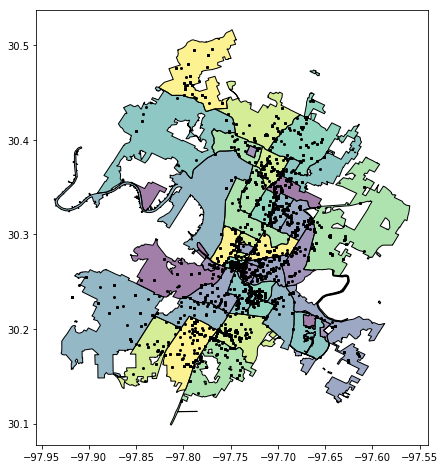

In [4]:
ax = agdf.plot(figsize = (8, 8))
auof_g.plot(ax = ax, color = "black")

In [5]:
# Do a spatial join, putting the points of crime in polygons.
auof_gm = gpd.sjoin(auof_g, agdf, how = "left", op = "within")
acri_gm = gpd.sjoin(acri_g, agdf, how = "left", op = "within")

# Aggregate both datasets by District
dist_cri_gm_county = acri_gm.groupby("district_n").count()[["code"]].rename(columns = {"code" : "Incidents"})
dist_uof_gm_county = auof_gm.groupby("district_n").count()[["code"]].rename(columns = {"code" : "Use of Force"})

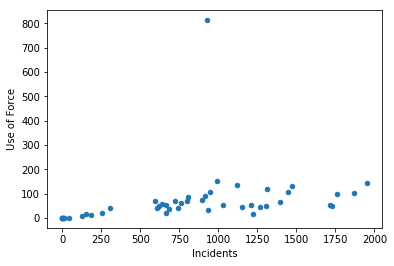

In [6]:
sc = pd.concat([dist_cri_gm_county, dist_uof_gm_county], axis = 1).fillna(0)
sc.plot(kind = "scatter", x = "Incidents", y = "Use of Force")

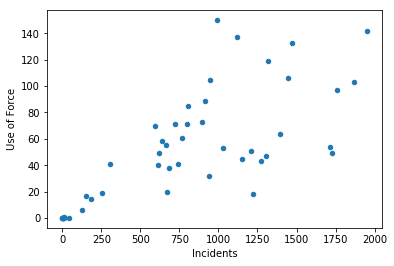

In [7]:
sc[sc["Use of Force"] < 500].plot(kind = "scatter", x = "Incidents", y = "Use of Force")

In [9]:
sc[sc["Use of Force"] > 500] # What's going on here??

,Incidents,Use of Force
GEORGE 2,929,812.0
